# Semantic Segmentation using Pytorch<br>
<img src='https://drive.google.com/uc?id=128KcBLobBPzRRaktc5pRf_xcd7uUCcT3' width=700><br>

Throughout this tutorial, we will be looking at image segmentation and building and training a segmentation model in PyTorch.<br>
We will be using U-Net which was originally proposed for medical image segmentation.

##UNET ARCHITECTURE

<img src='https://drive.google.com/uc?id=10b8-mr7pAB6STj7vyDkrOX2HUqvJ4jwb' width=600><br>


UNet consists of a contracting path and an expansive path.


1.   Contracting path:

  *   The contracting path follows the typical architecture of a convolutional network.

  * It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.

  * At each downsampling step we double the number of feature channels.


2.   Expansive path:
  * Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.

  * The cropping is necessary due to the loss of border pixels in every convolution.

  * At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes.

In total the network has 23 convolutional layers.<br><br>
In simple words there is a combination of upsampling and downsampling in a UNet. It is called a "U" Net because of its U like structure.



## Pytorch implementation

###1. Installing and importing all the necessities.

In [ ]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary
    !pip install PyMuPDF

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split


from torchvision.models import vgg16_bn


from tqdm import tqdm

class config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LEARNING_RATE = 1e-3
    N_EPOCHS = 20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 KB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.5 MB/s eta 0:00:00

###2. Dataset preprocessing

Now, we simply convert the input image to a tensor and normalize with image net values.

In [ ]:
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]
                                 )
                             ])


###3. Dataset Class

In [ ]:
class SegmentationData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split


    def __len__(self):
        return len(self.items)


    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))


        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))


        return image, mask


    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))


        ims = torch.cat([get_transforms()(im.copy()/255.)[None] for im in ims]).float().to(config.DEVICE)


        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(config.DEVICE)


        return ims, ce_masks


\__init__ ⟹ specifies the image location.

\__len__ ⟹ specifies the length of the dataset.

\__getitem__ ⟹ loads an image and mask and resizes them to the same size.

choose ⟹ selects a random image index for debugging.

collate_fn ⟹ performs preprocessing on a batch of images.



###4. DataLoaders<br>
Here we create a function to initialise the PyTorch dataset and create the dataloaders.

In [ ]:
def get_dataloaders():
  trn_ds = SegmentationData('train')
  val_ds = SegmentationData('test')


  trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
  val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)


  return trn_dl, val_dl


trn_dl, val_dl = get_dataloaders()


We first initialized the train and validation sets followed by obtaining the dataloaders.


### 5. UNet Architecture

First we define the convolution block.

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


It is followed by the up convolutional block.

In [ ]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )


Now that we have the building blocks, we leverage them to create the entire architecture.

In [ ]:
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()


        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])


        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)


        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)


        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)


        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)


        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)


        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)


        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)


        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)


        x = self.conv11(x)


        return x


Now, we can refer to the architecture diagram provided to understand how the above layers are interconnected.<br>
<img src='https://drive.google.com/uc?id=10b8-mr7pAB6STj7vyDkrOX2HUqvJ4jwb' width=600><br>


###6. Loss Function

We consider Cross Entropy Loss as a loss function because we have more than 2 classes. We can define a custom function to provide the loss and accuracies.

In [ ]:
ce = nn.CrossEntropyLoss()


def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc


### 7. Training engine.

The training engine consists of the training and validation loop function. These functions are pretty standard to PyTorch where you set the mode, obtain the outputs, calculate loss and update the weights!

In [ ]:
class engine():
  def train_batch(model, data, optimizer, criterion):
      model.train()


      ims, ce_masks = data
      _masks = model(ims)
      optimizer.zero_grad()


      loss, acc = criterion(_masks, ce_masks)
      loss.backward()
      optimizer.step()


      return loss.item(), acc.item()


  @torch.no_grad()
  def validate_batch(model, data, criterion):
      model.eval()


      ims, masks = data
      _masks = model(ims)


      loss, acc = criterion(_masks, masks)


      return loss.item(), acc.item()


We also define a function make_model() which provides the model, criterion and the optimizer.

In [ ]:
def make_model():
  model = UNet().to(config.DEVICE)
  criterion = UnetLoss
  optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  return model, criterion, optimizer


model, criterion, optimizer = make_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

###8. Train

For training we first iterate over the training dataloader and obtain the loss and accuracy followed by the validation dataloader.

In [ ]:
_epoch = []
_train_loss = []
_train_acc = []
_val_loss = []
_val_acc = []

def run():
  for epoch in range(config.N_EPOCHS):
      print("####################")
      print(f"       Epoch: {epoch}   ")
      print("####################")


      for bx, data in tqdm(enumerate(trn_dl), total = len(trn_dl)):
          train_loss, train_acc = engine.train_batch(model, data, optimizer, criterion)


      for bx, data in tqdm(enumerate(val_dl), total = len(val_dl)):
          val_loss, val_acc = engine.validate_batch(model, data, criterion)


      _epoch.append(epoch)
      _train_loss.append(train_loss)
      _train_acc.append(train_acc)
      _val_loss.append(val_loss)
      _val_acc.append(val_acc)



In [ ]:
run()

####################

Epoch: 0

####################

100%|██████████| 101/101 [00:02<00:00, 43.37it/s]


####################

Epoch: 1

####################

100%|██████████| 101/101 [00:02<00:00, 46.76it/s]


####################

Epoch: 2

####################

100%|██████████| 101/101 [00:02<00:00, 46.71it/s]


####################

Epoch: 3

####################

100%|██████████| 101/101 [00:02<00:00, 41.73it/s]


####################

Epoch: 4

####################

100%|██████████| 101/101 [00:02<00:00, 46.54it/s]


####################

Epoch: 5

####################

100%|██████████| 101/101 [00:02<00:00, 38.81it/s]


####################

Epoch: 6

####################

100%|██████████| 101/101 [00:02<00:00, 46.54it/s]


####################

Epoch: 7

####################

100%|██████████| 101/101 [00:02<00:00, 44.68it/s]


####################

Epoch: 8

####################

100%|██████████| 101/101 [00:02<00:00, 43.01it/s]


####################

Epoch: 9

####################

100%|██████████| 101/101 [00:02<00:00, 46.08it/s]


####################

Epoch: 10

####################

100%|██████████| 101/101 [00:02<00:00, 45.77it/s]


####################

Epoch: 11

####################

100%|██████████| 101/101 [00:02<00:00, 45.54it/s]


####################

Epoch: 12

####################

100%|██████████| 101/101 [00:02<00:00, 38.85it/s]


####################

Epoch: 13

####################

100%|██████████| 101/101 [00:02<00:00, 46.11it/s]


####################

Epoch: 14

####################

100%|██████████| 101/101 [00:02<00:00, 45.61it/s]


####################

Epoch: 15

####################

100%|██████████| 101/101 [00:02<00:00, 45.53it/s]


####################

Epoch: 16

####################

100%|██████████| 101/101 [00:02<00:00, 44.68it/s]


####################

Epoch: 17

####################

100%|██████████| 101/101 [00:02<00:00, 45.64it/s]


####################

Epoch: 18

####################

100%|██████████| 101/101 [00:02<00:00, 40.14it/s]


####################

Epoch: 19

####################

100%|██████████| 101/101 [00:02<00:00, 45.13it/s]


  0%|          | 0/101 [00:00<?, ?it/s]


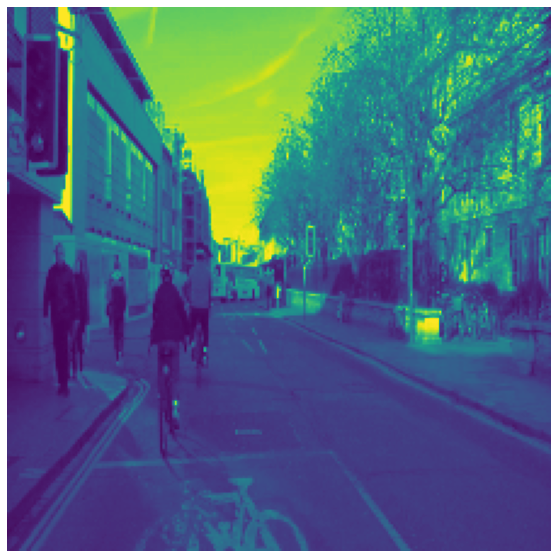

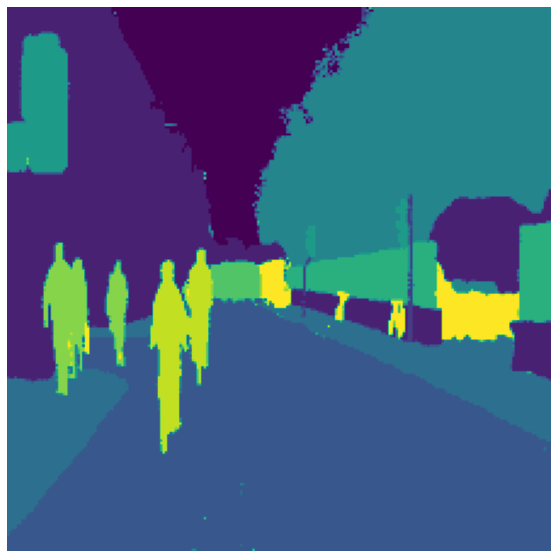

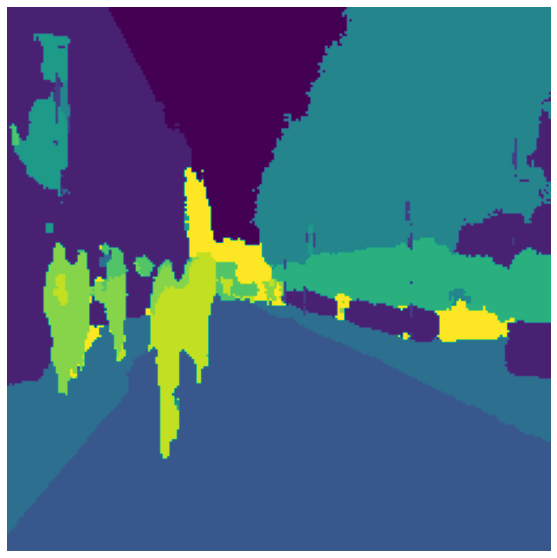

In [ ]:
for bx, data in tqdm(enumerate(val_dl), total = len(val_dl)):
    im, mask = data
    _mask = model(im)
    _, _mask = torch.max(_mask, dim=1)


    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(im[0].permute(1,2,0).detach().cpu()[:,:,0])



    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(mask.permute(1,2,0).detach().cpu()[:,:,0])



    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(_mask.permute(1,2,0).detach().cpu()[:,:,0])
    break

